<a href="https://colab.research.google.com/github/y001003/Bootcamp/blob/main/ai06_sc23x_%EB%B0%95%EC%98%81%EC%88%98_2%EC%B0%A8%EC%A0%9C%EC%B6%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS SC23x 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 데이터를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 이 [PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 오늘 여러분은 Chicago시의 공중보건부가 진행한 위생 검사의 실패 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install xgboost==1.4.2
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [2]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

In [3]:
# analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn.model_selection
from sklearn.model_selection import train_test_split

# pipeline
from sklearn.pipeline import make_pipeline

# encoding
from category_encoders import TargetEncoder, OrdinalEncoder

# Imputing
from sklearn.impute import SimpleImputer, KNNImputer

# model
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 

# metrics
from sklearn.metrics import f1_score, roc_auc_score, classification_report, roc_curve

# hyperparameter Tunning
from sklearn.model_selection import RandomizedSearchCV

# model Visualization
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Part 1: 데이터 전처리 (Data Preprocessing)

In [4]:
## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요
#> EDA를 하는 방식 및 라이브러리에 대한 제한은 없습니다. 단, 시간 분배에 주의하세요.

In [5]:
# 이 곳에 답안을 작성해주시길 바랍니다

In [6]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,2078428,OUTTAKES,RED MANGO,2125004.0,Restaurant,Risk 2 (Medium),10 S DEARBORN ST FL,CHICAGO,IL,60603.0,2017-08-14,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0
2,1591748,JAFFA BAGELS,JAFFA BAGELS,2278918.0,Restaurant,Risk 1 (High),225 N MICHIGAN AVE,CHICAGO,IL,60601.0,2015-12-15,Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,1230035,FRANKS 'N' DAWGS,FRANKS 'N' DAWGS,2094329.0,Restaurant,Risk 1 (High),1863 N CLYBOURN AVE,CHICAGO,IL,60614.0,2012-07-10,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,1228186,SOUTH COAST,SOUTH COAST SUSHI,1817424.0,Restaurant,Risk 1 (High),1700 S MICHIGAN AVE,CHICAGO,IL,60616.0,2013-09-20,Canvass,NaN,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    60000 non-null  int64  
 1   DBA Name         60000 non-null  object 
 2   AKA Name         59283 non-null  object 
 3   License #        59996 non-null  float64
 4   Facility Type    58573 non-null  object 
 5   Risk             59976 non-null  object 
 6   Address          60000 non-null  object 
 7   City             59955 non-null  object 
 8   State            59985 non-null  object 
 9   Zip              59987 non-null  float64
 10  Inspection Date  60000 non-null  object 
 11  Inspection Type  60000 non-null  object 
 12  Violations       44130 non-null  object 
 13  Latitude         59822 non-null  float64
 14  Longitude        59822 non-null  float64
 15  Location         59822 non-null  object 
 16  Inspection Fail  60000 non-null  int64  
dtypes: float64(4

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Inspection ID    20000 non-null  int64  
 1   DBA Name         20000 non-null  object 
 2   AKA Name         19765 non-null  object 
 3   License #        20000 non-null  float64
 4   Facility Type    19548 non-null  object 
 5   Risk             19998 non-null  object 
 6   Address          20000 non-null  object 
 7   City             19989 non-null  object 
 8   State            19997 non-null  object 
 9   Zip              19996 non-null  float64
 10  Inspection Date  20000 non-null  object 
 11  Inspection Type  20000 non-null  object 
 12  Violations       14664 non-null  object 
 13  Latitude         19940 non-null  float64
 14  Longitude        19940 non-null  float64
 15  Location         19940 non-null  object 
 16  Inspection Fail  20000 non-null  int64  
dtypes: float64(4

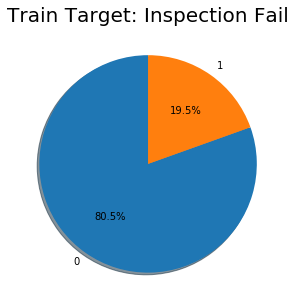

In [9]:
# target 확인 - train
import matplotlib.pyplot as plt

plt.subplots(figsize = (5,5))
plt.pie(train['Inspection Fail'].value_counts(), labels = train['Inspection Fail'].value_counts().index, 
        autopct="%.1f%%", shadow = True, startangle = 90)
plt.title('Train Target: Inspection Fail', size=20)
plt.show()

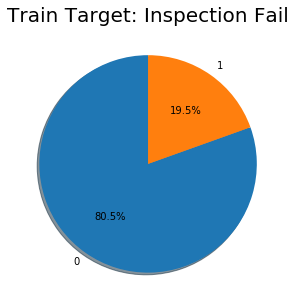

In [10]:
# target 확인 - train
import matplotlib.pyplot as plt

plt.subplots(figsize = (5,5))
plt.pie(train['Inspection Fail'].value_counts(), labels = train['Inspection Fail'].value_counts().index, 
        autopct="%.1f%%", shadow = True, startangle = 90)
plt.title('Train Target: Inspection Fail', size=20)
plt.show()

In [11]:
# 결측치 확인
train.isnull().sum(), test.isnull().sum()

(Inspection ID          0
 DBA Name               0
 AKA Name             717
 License #              4
 Facility Type       1427
 Risk                  24
 Address                0
 City                  45
 State                 15
 Zip                   13
 Inspection Date        0
 Inspection Type        0
 Violations         15870
 Latitude             178
 Longitude            178
 Location             178
 Inspection Fail        0
 dtype: int64, Inspection ID         0
 DBA Name              0
 AKA Name            235
 License #             0
 Facility Type       452
 Risk                  2
 Address               0
 City                 11
 State                 3
 Zip                   4
 Inspection Date       0
 Inspection Type       0
 Violations         5336
 Latitude             60
 Longitude            60
 Location             60
 Inspection Fail       0
 dtype: int64)

In [12]:
# 중복값 확인
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [13]:
# Cardinality 확인
train.describe(include="all").T.sort_values("unique", ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Violations,44130,44035,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DBA Name,60000,20175,SUBWAY,830,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AKA Name,59283,19209,SUBWAY,1014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Address,60000,15244,11601 W TOUHY AVE,755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,59822,14533,"(-87.91442843927047, 42.008536400868735)",760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inspection Date,60000,2667,2013-11-14,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Facility Type,58573,366,Restaurant,39922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inspection Type,60000,55,Canvass,31913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,59955,39,CHICAGO,59771,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Risk,59976,4,Risk 1 (High),42839,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

In [14]:
# 이 곳에 답안을 작성해주시길 바랍니다

In [15]:
def eda_process(df):

  # 복사
  df_temp = df.copy()

  # City 컬럼 처리 : City_chicago 칼럼을 만들어서 Chicago가 맞는 곳 1 과 아닌 곳 0 으로 구분
  Chicago_list = ["CHICAGO", "312CHICAGO", "CHCICAGO","CHICAGO.", "CHICAGOI", "CHICAGOCHICAGO", "CCHICAGO"]
  df_temp["City"] = df_temp["City"].str.upper()
  df_temp["City_Chicago"] = [1 if i in Chicago_list 
                             else 0 
                             for i in df_temp['City']]
  
  # Inspection date : string에서 datetime으로 바꾼 후 연도, 월 추출
  df_temp["Inspection Date"] = df_temp['Inspection Date'].apply(pd.to_datetime)
  df_temp["year"] = df_temp["Inspection Date"].dt.year
  df_temp["month"] = df_temp["Inspection Date"].dt.month  
  
  # Facility type : Top10 가려내기, TOP10 이외는 etc로 처리
  df_temp["Facility Type"] = df_temp["Facility Type"].str.upper()
  facility_top10 = df_temp["Facility Type"].value_counts().sort_values(ascending=False).head(10).index.to_list()
  df_temp["Facility Type"] = [i if i in facility_top10 
                              else "ETC" 
                              for i in df_temp['Facility Type']]

  # Violations : 결측치 0으로 보완, "|"으로 Split 후 len()을 사용하여 위반사항 "개수"로 변환
  df_temp["Violations"].fillna(0, inplace=True)
  df_temp["Violations"] = [0 if i == 0 
                           else len(i.split("| ")) 
                           for i in df_temp["Violations"]]
  
  # License # : 결측치 0으로 보완, 고유번호 존재시 1
  df_temp["License #"].fillna(0, inplace=True)
  df_temp["License"] = [0 if i == 0
                        else 1
                        for i in df_temp["License #"]]
  
  # DBA Name : 대문자로 전환
  df_temp["Name"] = df_temp["DBA Name"].str.upper()

  # Risk : 결측치, All 행 삭제, High, Medium, Low -> 1, 2, 3으로 변경
  df_temp.dropna(subset=["Risk"], axis=0)
  df_temp.drop(df_temp.loc[df_temp['Risk']=='All'].index, inplace=True)
  df_temp.replace('Risk 1 (High)', 1, inplace=True)
  df_temp.replace('Risk 2 (Medium)', 2, inplace=True)
  df_temp.replace('Risk 3 (Low)', 3, inplace=True)

  features = ['Name', 'City_Chicago', 'year', 'month', 'Facility Type', 'Violations', 'License','Risk', 'Latitude','Longitude', 'Inspection Type', 'Inspection Fail']
  
  df_features = df_temp[features]

  return df_features

In [16]:
X_train = eda_process(train)
X_test = eda_process(test)

In [17]:
X_train.shape, X_test.shape

((59988, 12), (19999, 12))

# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

In [18]:
# 이 곳에 답안을 작성해주시길 바랍니다
target = 'Inspection Fail'
features = ['Name', 'City_Chicago', 'year', 'month', 'Facility Type', 'Violations', 'License','Risk', 'Latitude','Longitude', 'Inspection Type', 'Inspection Fail']

X_train, X_val, y_train, y_val = train_test_split(X_train, X_train[target], test_size=0.2, random_state = 2)

In [19]:
X_train = X_train.drop(target,axis=1)
X_val = X_val.drop(target,axis=1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((47990, 11), (47990,), (11998, 11), (11998,))

In [20]:
y_test = X_test[target]
X_test = X_test.drop(target,axis=1)

X_test.shape, y_test.shape

((19999, 11), (19999,))

## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 설치 및 설정에 시간이 소요되는 점을 감안하시기 바랍니다

In [21]:
# 이 곳에 답안을 작성해주시길 바랍니다
# pre process : encoding, Imputing
pre_process = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

# fit_transform, transform
X_train_processed = pre_process.fit_transform(X_train)
X_val_processed = pre_process.transform(X_val)

# model
xgb_cf = XGBClassifier(
    n_estimators=1000, 
    verbosity=0,
    max_depth=7,        
    learning_rate=0.2,
    n_jobs=-1,
    random_state=2
)

# early stopping 
eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

# fit
xgb_cf.fit(X_train_processed, y_train, 
          eval_set=eval_set,
          eval_metric='auc',
          early_stopping_rounds=100
         ) # 10 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-auc:0.83204	validation_1-auc:0.83130
[1]	validation_0-auc:0.83932	validation_1-auc:0.83544
[2]	validation_0-auc:0.84229	validation_1-auc:0.83643
[3]	validation_0-auc:0.84444	validation_1-auc:0.83875
[4]	validation_0-auc:0.84801	validation_1-auc:0.84145
[5]	validation_0-auc:0.85016	validation_1-auc:0.84238
[6]	validation_0-auc:0.85172	validation_1-auc:0.84247
[7]	validation_0-auc:0.85413	validation_1-auc:0.84366
[8]	validation_0-auc:0.85616	validation_1-auc:0.84473
[9]	validation_0-auc:0.85779	validation_1-auc:0.84522
[10]	validation_0-auc:0.85997	validation_1-auc:0.84564
[11]	validation_0-auc:0.86146	validation_1-auc:0.84573
[12]	validation_0-auc:0.86314	validation_1-auc:0.84611
[13]	validation_0-auc:0.86460	validation_1-auc:0.84633
[14]	validation_0-auc:0.86644	validation_1-auc:0.84637
[15]	validation_0-auc:0.86821	validation_1-auc:0.84696
[16]	validation_0-auc:0.86963	validation_1-auc:0.84717
[17]	validation_0-auc:0.87125	validation_1-auc:0.84734
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=2, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=0)

## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다)

In [28]:
# 이 곳에 답안을 작성해주시길 바랍니다
X_test_processed = pre_process.fit_transform(X_test)
y_test_pred = xgb_cf.predict(X_test_processed)
y_test_pred_proba = xgb_cf.predict_proba(X_test_processed)[:,-1]
y_test_pred_proba
#AUC Score
print('AUC score: ', roc_auc_score(y_test, y_test_pred_proba))

AUC score:  0.8456920015134071


In [25]:
# Classification report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     16101
           1       0.73      0.36      0.49      3898

    accuracy                           0.85     19999
   macro avg       0.80      0.67      0.70     19999
weighted avg       0.84      0.85      0.83     19999



## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [26]:
# 이 곳에 답안을 작성해주시길 바랍니다
# Hyperparams
dists = {
    'xgbclassifier__n_estimators': [100, 200, 500, 1000], 
    'xgbclassifier__max_depth': [3, 5, 7, 9], 
    'xgbclassifier__learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'xgbclassifier__max_delta_step' : [1, 2, 5]
}



clf = RandomizedSearchCV(
    xgb_cf, 
    param_distributions=dists, 
    n_iter=3, 
    scoring='f1',
    verbose=1,
    n_jobs=-1,
)

clf.fit(X_train_processed, y_train);

print('최적 하이퍼파라미터: ', clf.best_params_)
print('f1: ', clf.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 19.8min finished


최적 하이퍼파라미터:  {'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 5, 'xgbclassifier__max_delta_step': 2, 'xgbclassifier__learning_rate': 0.05}
f1:  0.4892623828897934


In [29]:
y_test_pred = clf.predict(X_test_processed)
# Classification report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     16101
           1       0.62      0.42      0.50      3898

    accuracy                           0.84     19999
   macro avg       0.75      0.68      0.70     19999
weighted avg       0.82      0.84      0.82     19999



## Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 2가지를 선택하세요 (시각화에 가장 중요한 것은 **여러분의 분석**입니다.):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [30]:
# 이 곳에 답안을 작성해주시길 바랍니다
# permuter 정의
permuter = PermutationImportance(
    clf, 
    scoring='f1', 
    n_iter=5,
    random_state=10
)


permuter.fit(X_val_processed, y_val);


feature_names = X_val.columns.tolist()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
)

Weight,Feature
0.2502 ± 0.0074,Violations
0.1077 ± 0.0082,Inspection Type
0.0513 ± 0.0103,year
0.0387 ± 0.0097,Longitude
0.0385 ± 0.0110,Latitude
0.0100 ± 0.0068,month
0.0050 ± 0.0067,Facility Type
0.0014 ± 0.0073,Name
0.0005 ± 0.0003,City_Chicago
0.0002 ± 0.0010,License


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


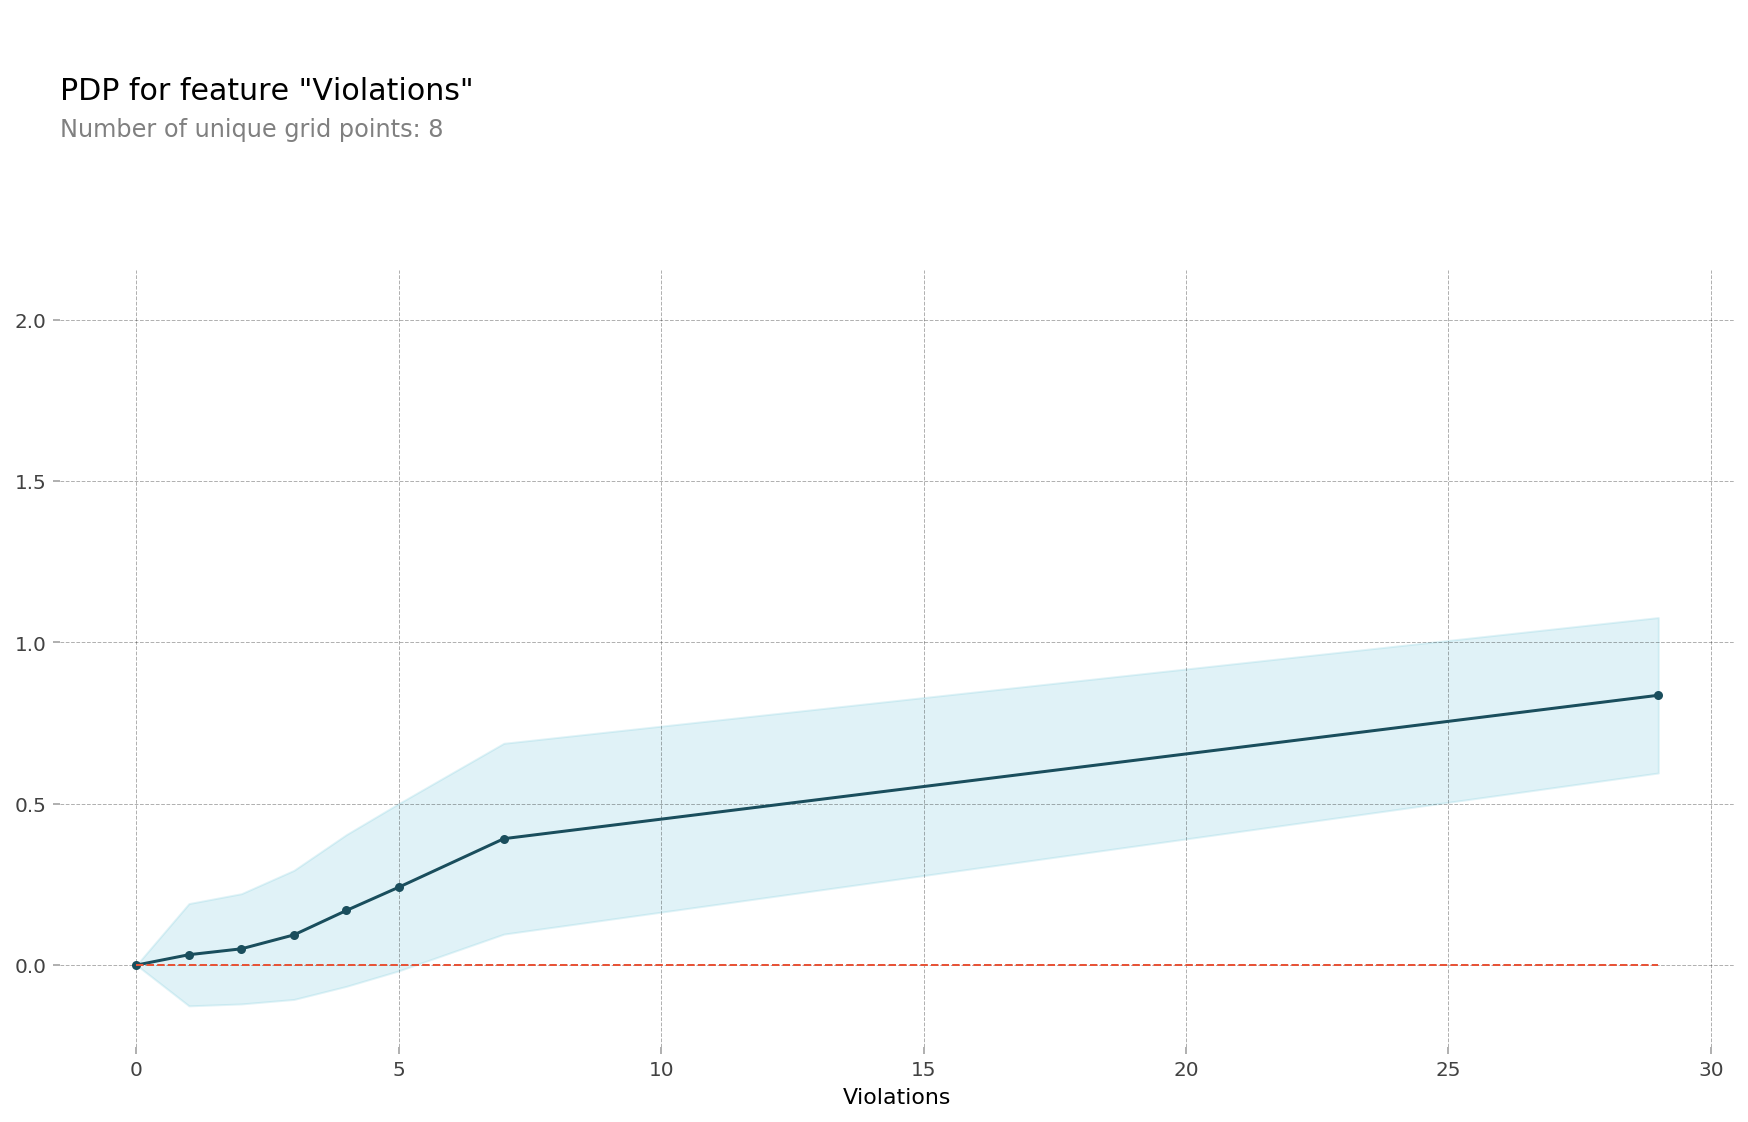

In [31]:
# PDP Plot

plt.rcParams['figure.dpi'] = 144

X_test_df = pd.DataFrame(X_test_processed, columns=X_test.columns)
X_test_df
feature = 'Violations'  # Permutation 최상위

pdp_isolated = pdp_isolate(
    model=clf, 
    dataset=X_test_df, 
    model_features=X_test_df.columns, 
    feature=feature)

pdp_plot(pdp_isolated, feature_name=feature);

In [32]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Violations', 'year']

interaction = pdp_interact(
    model=clf, 
    dataset=X_test_df,
    model_features=X_test_df.columns, 
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


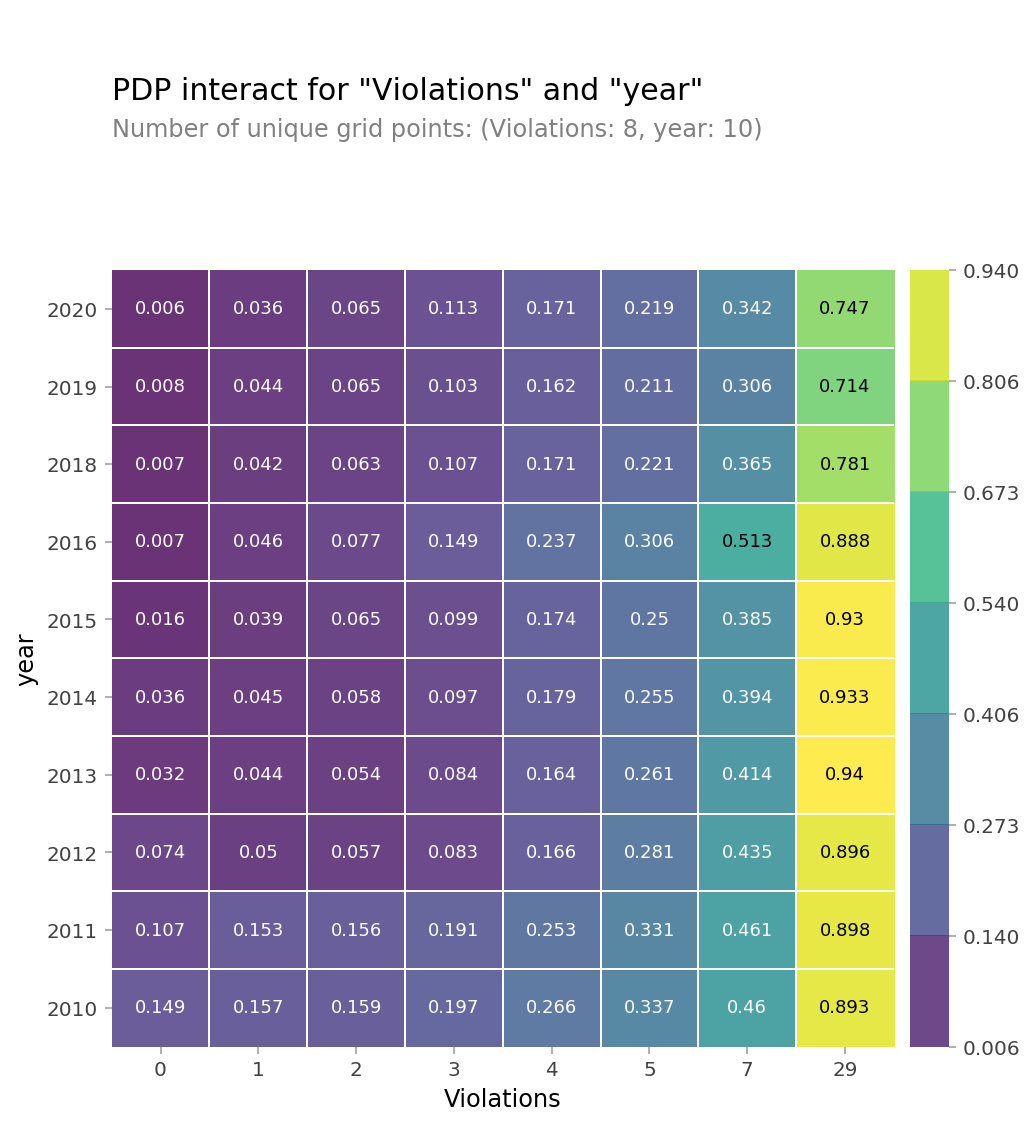

In [33]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);